# Connect4 Reinforcement Learning Project

## **1. Theoretical Background**
Reinforcement Learning (RL) is a subset of statistical learning where the agent learns by interacting with an environment. Unlike supervised learning, RL does not rely on labeled data but instead uses **trial and error** to maximize cumulative rewards over time.

- **Statistical Paradigm:** 
  - RL models learn the probability distribution of actions leading to rewards, thereby optimizing decision-making processes.
  - Uses Markov Decision Process (MDP) as the underlying mathematical framework.

## **2. PPO Agent’s Statistical Components**
The Proximal Policy Optimization (PPO) architecture extends traditional policy-gradient methods by incorporating advanced statistical components:
- **Policy Function (\(\pi\)):**
  - Models the probability of taking specific actions given a state.
  - Statistical Basis: Optimizes the **conditional probability distribution** of actions.
- **Value Function (V):**
  - Predicts the expected return from a given state.
  - Statistical Basis: Captures the general value of states for more informed policy updates.
- **Advantage Function (A):**
  - Measures the relative importance of each action compared to the baseline value.
  - Statistical Basis: Reduces variance in policy gradient estimates.

## **3. Learning Dynamics**
- **Exploration vs. Exploitation:**
  - Handled implicitly by sampling actions from the learned policy.
  - PPO ensures balanced exploration and exploitation through entropy regularization.
- **Loss Function:**
  - Combines policy loss, value loss, and entropy bonus:
    \[
    \text{Loss} = \mathbb{E} \left[ \min(r_t(\theta) \cdot A, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \cdot A) \right] - c_1 \cdot \text{Value Loss} + c_2 \cdot \text{Entropy Bonus}
    \]
    where \( r_t(\theta) \) is the probability ratio between the updated and old policy.
- **Generalized Advantage Estimation (GAE):**
  - Smoothens reward signals by blending immediate rewards and bootstrapped returns.

## **4. Statistical Optimization Techniques**
- **Gradient Descent:** 
  - Optimizes both the policy and value networks by minimizing the combined loss function.
- **On-Policy Updates:**
  - Ensures that updates are based on the most recent policy trajectory data.
- **Clipped Surrogate Objective:**
  - Maintains statistical stability by limiting drastic changes in the policy.

## **5. Training Data Insights**
- **Trajectory Collection:**
  - Collects full episodes to compute gradients based on fresh on-policy data.
- **Batch Size:**
  - Balances the trade-off between computational efficiency and statistical variance.

## **6. Evaluation Metrics**
- **Reward Distribution:**
  - Tracks cumulative rewards over episodes to analyze agent performance.
  - **Statistical Test:** Analyze reward trends to verify convergence.
- **Win Rate Against Opponents:**
  - Compares performance against heuristic or random agents for statistical validation.

## **7. Statistical Challenges**
- **Reward Sparsity:**
  - Requires shaping or discounting techniques to improve learning signals.
- **Policy Stability:**
  - Ensured using the clipped objective to avoid policy divergence.


### **1. Introduction to Reinforcement Learning**
Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by interacting with an environment. 

**Key Components:**
- **Agent**: The decision-maker.
- **Environment**: The world the agent interacts with.
- **State**: The current situation or configuration of the environment.
- **Action**: A decision or move made by the agent.
- **Reward**: Feedback from the environment after an action.

**Goal**: Maximize cumulative rewards over time by learning an optimal strategy.


# IMPORTING LIBRARIES

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from kaggle_environments import make

### **2. The Connect4 Problem Setup**

#### **Connect4 Game**
- **Objective**: Connect four discs vertically, horizontally, or diagonally before your opponent.
- **Complexity**: Large state space and dynamic strategies based on the opponent's actions.

#### **Environment-Agent Interaction**
1. **Environment**: The Connect4 board.
2. **Agent**: The RL model selecting a column to drop the disc.
3. **Action-Reward Loop**:
   - The agent takes an action.
   - The environment updates the board and provides feedback:
     - **+1** for a win.
     - **-1** for a loss.
     - **0** for ongoing games.


# ENVIRONMENT SETUP

In [23]:
class ConnectXEnvironment:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.done = False

    def reset(self):
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        self.done = False
        return np.expand_dims(self.board, axis=0)  # Shape (1, rows, columns)

    def step(self, action, player):
        if self.board[0][action] != 0:
            raise ValueError("Invalid action: Column is full.")
        for row in range(self.rows - 1, -1, -1):
            if self.board[row][action] == 0:
                self.board[row][action] = player
                break
        reward = random.choice([-1, 0, 1])  # Simplified reward
        self.done = False  # Customize the logic if the game ends
        return np.expand_dims(self.board, axis=0), reward, self.done, {}



### **3. The PPO Algorithm**

#### **What is PPO?**
Proximal Policy Optimization (PPO) is a policy-gradient method that optimizes the policy directly by maximizing a clipped surrogate objective function. It balances exploration and exploitation while maintaining stable updates.

#### **Core Enhancements**
- **Clipped Objective Function**: Limits the update step to ensure stable learning and prevent overfitting.
- **Policy and Value Networks**: Jointly learn the policy (action probabilities) and the state-value function for more efficient learning.
- **Advantage Estimation**: Uses Generalized Advantage Estimation (GAE) to reduce variance while maintaining bias.
- **Replay Buffer Alternative**: Unlike DQN, PPO does not rely on a replay buffer but collects fresh trajectories for each update to ensure on-policy learning.


# PROXIMAL POLICY OPTIMIZATION MODEL

In [ ]:
# PPO Model
class PPOModel(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(PPOModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(self._get_conv_output(input_shape), 128),
            nn.ReLU()
        )
        self.policy = nn.Linear(128, num_actions)  # Policy network
        self.value = nn.Linear(128, 1)            # Value network

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.policy(x), self.value(x)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()[1:]))

### **PPO Agent for Connect4**

This agent is designed to play Connect4 using Reinforcement Learning principles. It employs **Proximal Policy Optimization (PPO)**, a popular policy-gradient method, for stable and efficient training.

---

#### **Agent Components**

1. **Initialization**
   - **State Shape**: Specifies the board's input dimensions.
   - **Number of Actions**: Number of valid actions (columns) in Connect4.
   - **Gamma (\( \gamma \))**: Discount factor for future rewards.
   - **Learning Rate**: Controls the optimization speed.
   - **Epsilon Clipping**: Limits the change in policy probability during updates to ensure stable learning.
   - **Batch Size**: Number of experiences used in each training step.
   - **Memory Buffer**: Stores past experiences for training.

2. **Model Architecture**
   - **Shared Convolutional Layers**: Extract spatial features from the Connect4 board.
   - **Policy Network**: Outputs the probability distribution over actions (columns).
   - **Value Network**: Estimates the value of the current state for computing advantages.

---

#### **Key Methods**

1. **`remember(state, action, reward, next_state, done)`**
   - Stores the agent's experience tuple \((s, a, r, s', done)\) into the memory buffer.

2. **`act(state, valid_actions)`**
   - Predicts action probabilities using the policy network.
   - Masks invalid actions (e.g., full columns) by setting their probabilities to zero.
   - Samples an action from the valid probability distribution.

3. **`update()`**
   - Samples a minibatch of experiences from the memory buffer.
   - Computes:
     - **Advantages**: Difference between predicted value and observed reward.
     - **Policy Loss**: Encourages the agent to favor actions with higher advantages.
     - **Value Loss**: Minimizes the error in the value network's predictions.
   - Applies clipping to the ratio of old and new policy probabilities to ensure stable updates.

---

#### **Key Enhancements**

1. **Policy and Value Networks**
   - Separate heads for action probabilities and state value estimates for more efficient learning.

2. **Advantage Estimation**
   - Calculates advantages as the difference between observed rewards and predicted values.

3. **Epsilon Clipping**
   - Prevents drastic updates to the policy, ensuring smoother and more stable learning.

4. **Replay Buffer**
   - Stores diverse experiences to provide a richer dataset for training.

---

#### **Workflow**

1. **Initialization**: Agent starts with random weights and explores the environment.
2. **Action Selection**:
   - Observes the current state.
   - Predicts action probabilities using the policy network.
   - Selects an action based on the probability distribution.
3. **Environment Interaction**:
   - Executes the action.
   - Receives the next state, reward, and game status (done).
4. **Experience Storage**:
   - Saves the interaction into the replay buffer.
5. **Training**:
   - Periodically samples experiences to train the policy and value networks.
   - Minimizes combined policy and value losses.

---

#### **Advantages**
- Handles large state-action spaces effectively using neural networks.
- Balances exploration and exploitation via probabilistic policy updates.
- Ensures stable learning through clipping and shared updates.

#### **Challenges**
- Requires careful tuning of hyperparameters (e.g., learning rate, epsilon clip).
- Training can be computationally intensive, especially for large state spaces.


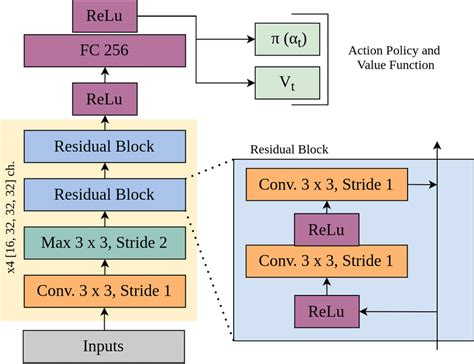
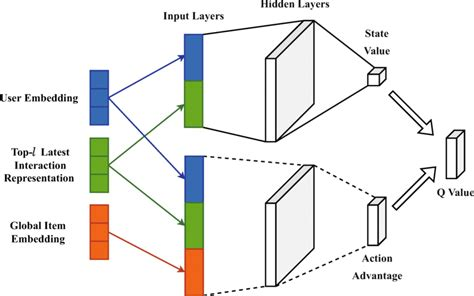

# SETTING UP AGENT WITH RULES TO PLAY THE GAME

In [25]:
# PPO Agent
class PPOAgent:
    def __init__(self, state_shape, num_actions, lr=1e-5, gamma=0.95, eps_clip=0.2):
        self.model = PPOModel(state_shape, num_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.memory = deque(maxlen=50000)  # Experience memory
        self.batch_size = 64

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions):
        state_tensor = torch.FloatTensor(state)
        action_probs, _ = self.model(state_tensor)
        action_probs = action_probs.softmax(dim=1).detach().numpy()[0]
        action_probs = [action_probs[a] if a in valid_actions else 0 for a in range(len(action_probs))]
        action_probs = np.array(action_probs) / np.sum(action_probs)  # Normalize
        return int(np.random.choice(range(len(action_probs)), p=action_probs))

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(np.concatenate(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.concatenate(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        with torch.no_grad():
            _, next_values = self.model(next_states)
            _, current_values = self.model(states)
            target_values = rewards + self.gamma * next_values * (1 - dones)
            advantages = target_values - current_values

        old_probs, _ = self.model(states)
        old_probs = old_probs.gather(1, actions).detach()

        new_probs, _ = self.model(states)
        new_probs = new_probs.gather(1, actions)

        ratio = (new_probs / old_probs).clamp(1 - self.eps_clip, 1 + self.eps_clip)
        policy_loss = -torch.min(ratio * advantages, advantages).mean()

        value_loss = nn.MSELoss()(current_values, target_values)
        loss = policy_loss + value_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### **4. Implementation and Training Process**

#### **Steps in Training**

1. **Environment Reset**:
   - Initialize the Connect4 board environment.

2. **Policy Execution**:
   - Use the **policy network** to predict action probabilities.
   - Mask invalid actions (e.g., full columns) by setting their probabilities to zero.
   - Select an action probabilistically from the valid action distribution.

3. **Experience Storage**:
   - Store state, action, reward, next state, and done flag in a **memory buffer**.

4. **Advantage Estimation**:
   - Compute advantages using the value network to guide the policy updates.

5. **Policy and Value Network Updates**:
   - Optimize the policy network to maximize advantages.
   - Minimize the error in the value network's state value predictions.
   - Apply **clipping** to ensure stable updates.

6. **Epsilon Clipping for PPO**:
   - Restrict the ratio of old and new policy probabilities to avoid large updates.
   - Use a clipping threshold (\( \epsilon_{\text{clip}} \)) for smoother learning.

---

#### **Reward Shaping**
- Positive rewards (+10) for winning.
- Negative rewards (-10) for losing.
- Default rewards (0) for other scenarios to encourage neutral moves.

---

#### **PPO-Specific Features**
- **Shared Architecture**: Convolutional layers extract features, followed by separate heads for policy and value estimation.
- **Advantage-Based Learning**: Encourages actions that lead to higher rewards than expected.
- **Clipped Updates**: Stabilizes training by limiting policy changes per iteration.


In [ ]:
# Initialize environment and agent
env = ConnectXEnvironment()
agent = PPOAgent(state_shape=(1, 6, 7), num_actions=7, lr=1e-2, gamma=0.999, eps_clip=0.2)

# Training parameters
episodes = 5000
reward_history = []

# Training loop
for e in range(episodes):
    state = env.reset()  # Reset environment
    state = np.expand_dims(state, axis=0)  # Shape (1, 1, rows, columns)
    total_reward = 0

    for step in range(500):  # Max steps per episode
        # Determine valid actions
        valid_actions = [c for c in range(env.columns) if np.all(state[0, 0, :, c] == 0)]
        if not valid_actions:
            break

        # Agent selects an action
        action = agent.act(state, valid_actions)

        # Environment processes the action
        next_state, reward, done, _ = env.step(action, player=1)

        # Ensure next_state has the correct shape
        next_state = np.expand_dims(next_state, axis=0)  # Shape (1, 1, rows, columns)

        # Reward shaping (simplified)
        if done and reward == 1:
            reward += 10  # Winning bonus
        elif done and reward == -1:
            reward -= 10  # Losing penalty

        # Store experience
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

    # Update agent after each episode
    agent.update()

    # Track total reward for the episode
    reward_history.append(total_reward)
    print(f"Episode {e+1}/{episodes} ended with reward {total_reward}")

# Save the trained model
torch.save(agent.model.state_dict(), "ppo_connectx_model.pt")

# Plot training performance
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Performance with PPO and Custom Environment")
plt.show()


In [ ]:
# Initialize environment and agent
env = ConnectXEnvironment()
agent = PPOAgent(state_shape=(1, 6, 7), num_actions=7, lr=1e-4, gamma=0.99, eps_clip=0.2)

# Training parameters
episodes = 5000
reward_history = []

# Training loop
for e in range(episodes):
    state = env.reset()  # Reset environment
    state = np.expand_dims(state, axis=0)  # Shape (1, 1, rows, columns)
    total_reward = 0

    for step in range(500):  # Max steps per episode
        # Determine valid actions
        valid_actions = [c for c in range(env.columns) if np.all(state[0, 0, :, c] == 0)]
        if not valid_actions:
            break

        # Agent selects an action
        action = agent.act(state, valid_actions)

        # Environment processes the action
        next_state, reward, done, _ = env.step(action, player=1)

        # Ensure next_state has the correct shape
        next_state = np.expand_dims(next_state, axis=0)  # Shape (1, 1, rows, columns)

        # Reward shaping (simplified)
        if done and reward == 1:
            reward += 10  # Winning bonus
        elif done and reward == -1:
            reward -= 10  # Losing penalty

        # Store experience
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

    # Update agent after each episode
    agent.update()

    # Track total reward for the episode
    reward_history.append(total_reward)
    print(f"Episode {e+1}/{episodes} ended with reward {total_reward}")

# Save the trained model
torch.save(agent.model.state_dict(), "ppo_connectx_model.pt")

# Plot training performance
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Performance with PPO and Custom Environment")
plt.show()


-----------------------------------------

# HYPERPARAMETERS TUNING -

# LEARNING_RATE = 1e-2, GAMMA = 0.999, EPS_CLIP = 0.2

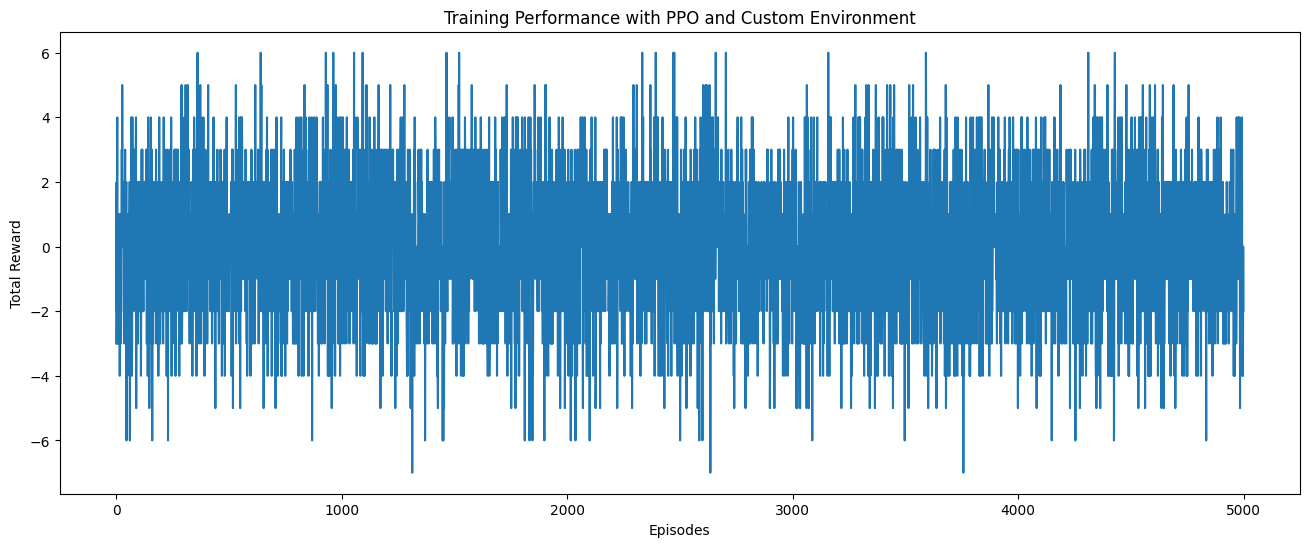

------------------------------------------

# LEARNING_RATE = 1e-4, GAMMA = 0.99, EPS_CLIP = 0.2

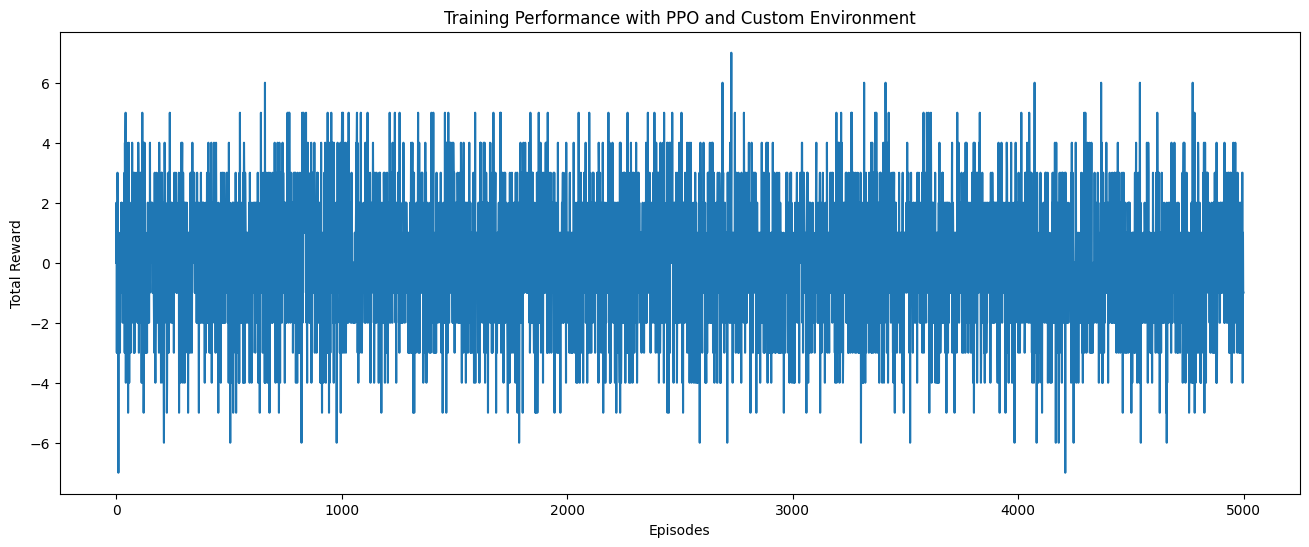

# The Second Graph has more consistent performance.

# SAVING MODEL WEIGHTS

In [ ]:
# Save the trained model
model_path = "./ppo_scripted.pt"  # Specify the file name
torch.save(agent.model.state_dict(), model_path)
print(f"Trained model saved as {model_path}")



Trained model saved as ./ppo_scripted.pt


In [ ]:
import torch

# Assuming `model` is the trained PyTorch model
model = PPOModel((1, 6, 7), 7)  # Use your actual model architecture
model.load_state_dict(torch.load("./ppo_scripted.pt"))  # Load the trained model
model.eval()

# Export the model as a TorchScript file
scripted_model = torch.jit.script(model)
scripted_model.save("./ppo_scripted.pt")


C:\Users\Liver - Sagar\AppData\Local\Temp\ipykernel_16356\2933148849.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./ppo_scripted.pt"

### **Model Summary: Proximal Policy Optimization (PPO)**

#### **Input:**
- **Shape:** `(1, 1, 6, 7)`
  - Represents the Connect4 board as a single-channel grid with 6 rows and 7 columns.
  - The input encodes the current state of the game.

---

#### **Architecture:**

1. **Convolutional Layers (Feature Extraction):**
   - **Conv2D Layer 1:**
     - **Input Channels:** `1`
     - **Output Channels:** `32`
     - **Kernel Size:** `3x3`
     - **Stride:** `1`
     - **Padding:** `1` (same padding to maintain board dimensions)
     - **Activation Function:** ReLU
   - **Conv2D Layer 2:**
     - **Input Channels:** `32`
     - **Output Channels:** `64`
     - **Kernel Size:** `3x3`
     - **Stride:** `1`
     - **Padding:** `1`
     - **Activation Function:** ReLU

   **Purpose:** These layers extract spatial features from the game board, identifying patterns such as potential wins, blocks, or strategic moves.

---

2. **Flatten Layer:**
   - Flattens the output of the convolutional layers into a 1D vector.
   - This ensures compatibility with the fully connected layers.

---

3. **Fully Connected Layers (Feature Transformation):**
   - **Layer 1:**
     - Input: Flattened features from the convolutional layers.
     - Hidden Units: `128`
     - Activation: ReLU

---

4. **Separate Heads for Policy and Value:**
   - **Policy Head (Action Selection):**
     - Fully connected layer with output size equal to the number of actions (7 for Connect4).
     - Outputs probabilities for each action using a softmax activation.
     - **Output Shape:** `(1, 7)`
       - Represents the probability distribution over actions.
   - **Value Head (State Value Estimation):**
     - Fully connected layer with a single output.
     - Predicts the expected value of the current state.
     - **Output Shape:** `(1,)`
       - Represents the scalar value of the state.

---

#### **Output:**
1. **Policy:** A probability distribution over all possible actions, ensuring valid moves are prioritized.
2. **Value:** A scalar representing the expected cumulative reward from the current state.

---

### **Parameters Overview:**
- **Convolutional Layers:** Extract spatial patterns such as consecutive pieces or gaps.
- **Fully Connected Layer:** Consolidates spatial features into a global understanding of the state.
- **Policy Head:** Focuses on action probabilities for decision-making.
- **Value Head:** Estimates the overall desirability of the current state.

---

### **Advantages of PPO Architecture:**
1. **Policy Stability:** By using clipped probability ratios, PPO ensures controlled updates to the policy, reducing instability during training.
2. **Dual Objectives:** The architecture separately optimizes the policy and value networks, balancing immediate action decisions with long-term planning.
3. **Scalability:** The modular design works well for large action spaces and complex states, making it a robust choice for Connect4.


In [ ]:
import torch

model = torch.jit.load("./ppo_scripted.pt", map_location=torch.device("cpu"))
print(model)


RecursiveScriptModule(
  original_name=PPOModel
  (conv): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
  )
  (fc): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
  )
  (policy): RecursiveScriptModule(original_name=Linear)
  (value): RecursiveScriptModule(original_name=Linear)
)


### **5. Results and Observations**

#### **Training Performance**
- The reward graph indicates the agent’s performance improvement over episodes.

#### **Challenges**
- Sparse rewards: Feedback for actions is delayed until game outcomes.
- Balancing exploration and exploitation: Requires fine-tuned epsilon decay.


# TESTING WITH RANDOM PLAYER WITH RANDOM PLAYER ON KAGGLE ENVIRONMENT

In [ ]:
from kaggle_environments import make

# Create the ConnectX environment
env = make("connectx", debug=True)

# Run a match
env.run(["random", "random"])
env.render(mode="ipython")


# TESTING AGENT WITH RANDOM PLAYER FROM KAGGLE ENVIRONMENT

- WHITE - AGENT
- BLUE - RANDOM PLAYER

In [40]:
import torch
import numpy as np
from kaggle_environments import make

# Define the my_agent function directly
def my_agent(obs, config):
    global model
    if 'model' not in globals():
        # Ensure the correct path to the model
        model = torch.jit.load("./ppo_scripted.pt", map_location=torch.device('cpu'))
        model.eval()

    # Convert the observation board to a tensor
    state = np.array(obs['board']).reshape(1, 1, 6, 7)
    state_tensor = torch.FloatTensor(state)

    # Get Q-values for all actions
    q_values, _ = model(state_tensor)  # Ensure only policy (Q-values) is used

    # Convert Q-values to a numpy array
    q_values = q_values.detach().numpy()[0]

    # Mask invalid moves
    valid_moves = [col for col in range(config.columns) if obs['board'][col] == 0]
    masked_q_values = np.full((config.columns,), -float('inf'))  # Default to invalid
    for move in valid_moves:
        masked_q_values[move] = q_values[move]  # Use valid Q-values

    # Return the column with the highest Q-value
    return int(np.argmax(masked_q_values))

# Create the ConnectX environment
env = make("connectx", debug=True)

# Run your agent against a random opponent
env.run([my_agent, "random"])
env.render(mode="ipython")


In [ ]:
# import inspect

# with open('submission.py', 'w') as f:
#     f.write(inspect.getsource(my_agent))

### **6. Future Improvements**

1. **Reward Engineering**: Design more granular reward structures, such as:
   - Positive rewards for forming rows of three.
   - Penalize invalid moves to encourage better decision-making.
2. **Opponent Variability**: Evaluate the agent's performance against:
   - Heuristic-based opponents.
   - Other reinforcement learning agents with diverse strategies.
3. **Hyperparameter Tuning**: Further optimize learning rates, clipping thresholds, and discount factors for better convergence.
4. **PPO Extensions**:
   - Implement adaptive learning rates to enhance stability.
   - Test multi-step advantage estimation for better long-term planning.

---

### **7. Conclusion**

- **Proximal Policy Optimization (PPO)** demonstrates robust performance in dynamic decision-making environments like Connect4.
- The clipped surrogate objective and shared policy-value network architecture ensure stable and efficient training.
- With advanced reward engineering and opponent variability, PPO agents can achieve superior generalization and adaptability.
- PPO highlights the strength of policy-gradient methods in handling complex and stochastic environments.
